# Reddit Sentiment-based Soccer Match Prediction

In this project, my goal is to predict the soccer match results based on the sentiment of the comments in the corresponding Reddit soccer (r/soccer) post-match threads. First, I collect the raw data using reddit API. For each match, I design and compute various sentiment metrics classified by the commenter's flair (team). Second, using statistical tests, I draw inferences on the variance in the sentiment for different flair types across different results. Using this analysis, I evaluate machine learning models for match result prediction based on the sentiment.

## Table of Contents

1. [Introduction](#introduction)

2. [Setup](#setup)

3. [Data Collection](#data-collection)

4. [Exploratory Data Analysis](#eda)

5. [Inferential Statistics](#stat-inference)

6. [Data Imputation](#data-imputation)

7. [Binary Classification](#binary-classification)

8. [Conclusion](#conclusion)

<a id ="introduction"></a>

## 1. Introduction 

Reddit is a social news website and forum where content is socially curated and promoted by site members through voting. Subreddits are communities centered around a topic, running from rather broad (like the r/worldnews subreddit) or super niche, like the subreddit for discussing Manchester United midfielder Ander Herrera's goal celebrations (r/herreracelebrations/). 

In this project, I focus on the subreddit for soccer content [/r/soccer](https://www.reddit.com/r/soccer/), comprising of an enormous community of over 500,000 subscribers. This is the largest sports-related subreddit! Hundreds of submissions (posts) are voted based on their content and discussed on a daily basis. The common submissions include live goals, news articles and pre-, live and post-match analysis. Many a time /r/soccer is where I vent my frustration whenever Manchester United suffers defeat!  The anonymity of Reddit provides a powerful tool for users to express their opinions about the clubs they support and also rival clubs. This unique feature provides a mechanism to prevent the building of echo chambers which was a hot topic in the recently held 2016 US elections.

/r/soccer also provides each subscriber the feature to select a "flair" which is the team crest (team logo) of the club/country the user supports. A miniature team logo is displayed beside the username in their posts and comments. This gives other readers context and insight into the user's thinking and adds another interesting dimension to the conversations that take place. In this project, I focus on the Post-Match Threads which are discussion threads created immediately after a soccer match has ended. My hypothesis is that the sentiment of the commenters supporting the team that lost is widely different from the commenters supporting the team that won. And when the game is a draw, the sentiment for both teams might be a bit closer. However, during the 90 min of football, one usually goes through a wide variety of emotions independent of your team winnning or losing. Sometimes the result might be a draw but the equalizer would've been scored in the dying minutes of the game. In that case, the supporters of the team that scored in the final minutes are expected to have a better feeling at the end of the game. Is it possible to capture these emotions in the post-match threads? That is basically the goal of this project.

Using [Python Reddit API wrapper](https://praw.readthedocs.io/en/latest/) (praw), we can easily extract Reddit data. You can filter submissions from a particular subreddit during a specific period and add additional search queries to filter the submissions. For a given submission, you can access the data at individual comment level. For example, in this project, I utilize the top 10 comments for each flair type.

<a id="setup"></a> 

## 2. Setup 

In [315]:
# Data Collection and Transformations
import praw
import numpy as np
import pandas as pd
import datetime as dt
import time
import unicodedata
import re
import editdistance
import pickle
from sklearn.preprocessing import Imputer 

# Sentiment Analysis
from textblob import TextBlob

# Statistical Testing
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve, auc, classification_report

# Class imbalance 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

# Plotting 
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,8]
import seaborn as sns
%matplotlib inline

<a id ="data-collection"></a>

# 3. Data Collection 

In this sub-section, I perform the data collection and computation of the metrics of interest. Our final dataframe will include each submission in its own row and its metrics and other info in the columns. Therefore, the metrics are computed at a per-submission granularity. The key concepts of data generation are as follows:

1. **Match Info**: For each Post-Match Thread (submission), I find out the two teams that are taking part and the Match Score. This information can be obtained using regular expressions on the submission title alone. The title is usually in the following format: 
 [Post Match Thread] Manchester United 3-0 Liverpool (English Premier League). In this classification, Manchester United is the home team, Liverpool is the away team and the final score is 3-0. The match result has 3 possible values: 1 if home team wins, 0 in case of a draw and -1 when the away team wins.

2. **Flair-based Classification**: Once the team names are learnt, I classify the comments based on the commenter's flair i.e. supporting team. There are 3 classes of classification: Home, Away and Others. Others refers to commenters with other team flairs.

3. **Per-Flair Sentiment Metrics**: For each flair type, I find out the top Ntop comments among all the comments in the submission. Then, using textblob NLP package, I find out the subjectivity and sensitivity of the filtered comments individually and together. I compute the weighted averages of sentiment polarity based on two kinds of weight, subjectivity and comment score. Also, the standard deviation in the polarity is recorded. 

Apart from the sentiment metrics, I also collect the submission score (~ number of upvotes), total number of comments and submission creation time. In this manner, each record is generated. For this project, I used submissions during the period Feb 9, 2014 to April 5, 2017. To reduce the standard deviations in the user sentiment within a flair typeof a given submission, I only used the submissions with a minimum of 100 comments.

The following cells in this sub-section execute the above key concepts in code.

### 3.1 Reddit Agent Initialization

In [ ]:
reddit = praw.Reddit(user_agent = 'xxxx',client_id = 'xxxx',client_secret = 'xxxx',username='xxxx',password='xxxxx')
print(reddit.user.me())

In [ ]:
# Datetime objects
start_date = dt.date(2013,1,1)
end_date = dt.date(2017,4,5)
# Converting to UNIX timestamp
start_time = int(time.mktime(start_date.timetuple()))
end_time = int(time.mktime(end_date.timetuple()))

In [ ]:
subreddit = reddit.subreddit('soccer')
#Typical terms in a submission on /r/soccer for Post-Match Thread
query = "(and title:'post-match thread')"
#List of Submission instances
submissions = subreddit.submissions(start = start_time, end = end_time, extra_query=query)

In [ ]:
def string_normalize(x):
    """
    Function to normalize special characters in non-English languages
    Input: 
    x: Sentence
    Output: 
    Transformed sentence
    """
    if not x:
        return
    
    x = unicodedata.normalize('NFD',x).encode('ascii','ignore')
    return x.decode("utf-8")

In [ ]:
def get_match_info(submission_title):
    """
    Function to extract the team names and match score from the title
    Input: 
    submission_title: Reddit submission title
    Output: 
    match_info: list [Team A name, Team A score, Team B score, Team B name]  
    """
    # Regular expression to get groups (Team A), (Team A score), (Team B score), (Team B)
    match = re.search(r'Thread.\s(\w+)\s(\w*)\s*(\d+)\s*-\s*(\d+)\s(.+)',submission_title)
    if not match:
        return None
    else:
        match_info = list(match.groups())
        
        # If team A has two words, then join
        if match_info[1]:
            match_info[0] += ' ' + match_info[1]
        
        del match_info[1]
        
        # If second team name has additional Competition name e.g. (English Premier League)
        if "(" in match_info[3]:
            match_info[3] = match_info[3].split(" (")[0]
        elif "[" in match_info[3]:
            match_info[3] = match_info[3].split(" [")[0]
            
        return match_info

### 3.2 Sentiment Computation Functions

In [ ]:
def compute_sentiment(comment):
    """
    Returns the sentiment polarity of the comment body
    using textblob package
    input: comment instance
    output: 
    sentiment property is a namedtuple of the form 
    Sentiment(polarity, subjectivity). The polarity 
    score is a float within the range [-1.0, 1.0]. 
    The subjectivity is a float within the range 
    [0.0, 1.0] where 0.0 is very objective and 1.0 
    is very subjective.
    """
    return TextBlob(comment.body).sentiment

def comments_sentiment(comments_list, Ntop = None):
    """
    Function to sort the comments in the given list of comments,
    extract the top Ntop comments and return list of sentiment
    polarities.
    Inputs: 
    comments_list            : list of comments
    Ntop                     : Number of top comments from each flair type for whom
                               sentiment polarities will be collected. If None, all 
                               comments will be considered.
    Outputs:
    polarity_by_score        : polarity weighted by comments
    polarity_by_subjectivity : polarity weighted by subjectivity
    polarity_std             : standard deviation of polarities of individual comments
    polarity_overall         : Polarity obtained by combining top N comments together
    """
    
    # empty list, return NaN
    if not len(comments_list):
        return [np.nan]*3
    
    if not Ntop:
        Ntop = len(comments_list)
    
    comments_list.sort(key= lambda comment: comment.score, reverse=True)
    
    # Computing weighted polarity based on comment score and based on subjectivity
    comments_score = [comment.score for comment in comments_list[:Ntop]]
    comments_polarity = []
    comments_subjectivity = []
    
    for comment in comments_list[:Ntop]:
        sentiment = compute_sentiment(comment)
        comments_polarity.append(sentiment.polarity)
        comments_subjectivity.append(sentiment.polarity)
    
    polarity_by_score = (np.sum(np.multiply(comments_polarity,comments_score))/
                         np.sum(comments_score))
    polarity_by_subjectivity = (np.sum(np.multiply(comments_polarity,comments_subjectivity))/
                                len(comments_subjectivity))
    polarity_std = np.std(comments_polarity)
    
    comments_overall = " ".join([comment.body for comment in comments_list[:Ntop]])
    polarity_overall = TextBlob(comments_overall).sentiment.polarity
    
    return [polarity_by_score,polarity_by_subjectivity,polarity_std,polarity_overall]

def submission_sentiment(submission,team_a,team_b, Ntop = None):
    """
    Function to obtain the sentiment polarities for top N highest 
    scoring comments for each of Team A, Team B and Other commenter
    flairs.
    Inputs: 
    submission       : submission instance
    team_a           : Team A name
    team_b           : Team B name
    
    Output: 
    polarity_metrics : combined list of polarity metrics for all flair types
    """
    
    submission.comments.replace_more(limit=0)
    team_a_comments = []
    team_b_comments = []
    other_comments = []
    
    
    ## Classfication of comments based on flair
    for comment in submission.comments.list():
        
        flair = string_normalize(comment.author_flair_text)
        
        """
        Failing to detect whether a comment's flair belongs to
        Team A or Team B when it actually belongs to one of the teams
        will lead to incorrect classification as Other Teams flair type.
        This results in an incorrect record generation. Examples include:
        Hoffenheim in title has flair 1899 Hoffenhiem, West Brom in title 
        has flair West Bromwich Albion etc. Simple approach to take care
        of above cases is to check if team name is stored in flair. However, 
        this does not address. Bayern Munich in title having flair 
        Bayern Munchen in comments.
        Therefore, an extra condition for checking edit distance lesser than
        equal to 3 is provided.
        """
        if not flair: 
            other_comments.append(comment)
        else:
            if team_a in flair:
                team_a_comments.append(comment)
            elif team_b in flair:
                team_b_comments.append(comment)
            elif editdistance.eval(team_a,flair) <= 3:
                team_a_comments.append(comment)
            elif editdistance.eval(team_b,flair) <= 3:
                team_b_comments.append(comment)
            else:
                other_comments.append(comment)
            
    # Combining the sentiment polarities and filling missing values
    polarity_metrics = []
    polarity_metrics += (comments_sentiment(team_a_comments, Ntop) +
                         comments_sentiment(team_b_comments, Ntop) +
                         comments_sentiment(other_comments, Ntop))          
                         
    return polarity_metrics

### 3.3 Record generation per Submission

In [ ]:
data = []

for submission in submissions:
    
    title = string_normalize(submission.title)
    
    # Excluding threads with less than 100 comments
    if(submission.num_comments < 100):
        continue
    
    # Get Match Info
    match_info = get_match_info(title)
    
    # If title doesn't match with regex format
    if not match_info:
        continue
    else:
        # List for current record
        record = []
        
        # Score: + 1 if Team A won; 0 if Team B won; -1 if Team B won
        match_result = int(match_info[1]) - int(match_info[2])
        if match_result:
            match_result = match_result/abs(match_result)
        record.append(match_result)
    
        # Title
        record.append(title)
    
        # Submission Creation Time
        creation_time = time.ctime(submission.created)
        record.append(creation_time)
        #print(creation_time)
    
        # Team Names
        team_a = match_info[0].strip()
        team_b = match_info[3].strip()
        record.append(team_a)
        record.append(team_b)
        
        # Get sentiments 
        polarity_metrics = submission_sentiment(submission, team_a,team_b,Ntop = 10)
        record += polarity_metrics
        
        # Submission Score and Number of Comments
        record.append(submission.num_comments)
        record.append(submission.score)
        
        # Append to the main list
        data.append(record)

In [158]:
raw_df = pd.DataFrame(data)
raw_df.columns = (["Result","Title","Time","Home Team","Away Team","Home Team Score Pol",
                   "Home Team Subject Pol","Home Team Pol SD","Home Team Merged Pol","Away Team Score Pol",
                  "Away Team Subject Pol","Away Team Pol SD","Away Team Merged Pol","Others Score Pol",
                  "Others Subject Pol","Others Pol SD","Others Merged Pol","Comments","Submission Score"])

In [ ]:
raw_df.shape

Let's dump the generated dataframe into a pickle file to enable reuse.

In [ ]:
pickle.dump(raw_df, open( "top_10_merged_df.pckl", "wb" ))

<a id="eda".</a>

# 4. Exploratory Data Analysis

To analyze the sentiment analysis in isolation, I do not consider the team names, submission scores and number of comments as features for the match result prediction. Therefore, the features include only polarity metrics. The response variable is the Match result.

Before the transform, **we split the dataset into training(90%) and test (10%) sets.** I use the test dataset only for the final prediction.

In [159]:
train_df, test_df = train_test_split(raw_df, test_size = 0.1)

In [160]:
train_df.head()

,Result,Title,Time,Home Team,Away Team,Home Team Score Pol,Home Team Subject Pol,Home Team Pol SD,Home Team Merged Pol,Away Team Score Pol,Away Team Subject Pol,Away Team Pol SD,Away Team Merged Pol,Others Score Pol,Others Subject Pol,Others Pol SD,Others Merged Pol,Comments,Submission Score
310,1.0,Post-Match Thread: Napoli 4-2 Milan [Serie A],Sat Aug 27 23:45:33 2016,Napoli,Milan,0.477641,0.164769,0.250681,0.174040,0.077015,0.073719,0.257644,0.072777,-0.187607,0.229740,0.474747,0.004489,179.0,225.0
701,0.0,Post Match Thread: Leicester City 1-1 Tottenha...,Sat Aug 22 18:54:57 2015,Leicester City,Tottenham Hotspur,0.207044,0.101017,0.266720,0.235485,0.222321,0.149548,0.264658,0.195730,0.064273,0.070864,0.235325,0.161905,156.0,120.0
521,0.0,[Post Match Thread] Juventus 2 - 2 Bayern Munich,Tue Feb 23 23:39:18 2016,Juventus,Bayern Munich,-0.073774,0.100327,0.310462,0.078559,0.245735,0.133492,0.322366,0.087457,0.026900,0.023127,0.147305,0.016406,727.0,596.0
246,-1.0,Post Match Thread: Netherlands 0 - 1 France [W...,Mon Oct 10 23:42:00 2016,Netherlands,France,-0.053231,0.184059,0.389590,-0.025123,0.166324,0.245321,0.412635,0.275033,0.443235,0.260489,0.349601,0.264163,222.0,110.0
898,1.0,[Post Match Thread] Argentina 2-1 Bosnia and H...,Mon Jun 16 02:51:11 2014,Argentina,Bosnia and Herzegovina - Group F,0.160976,0.166814,0.320937,0.203657,NaN,NaN,NaN,-0.072189,0.073393,0.260801,-0.069549,678.000000,363.0,NaN


In [292]:
X_train = train_df.iloc[:,5:]
y_train = train_df.iloc[:,0]

X_test = test_df.iloc[:,5:]
y_test = test_df.iloc[:,0]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((819, 12), (819,), (92, 12), (92,))

In [168]:
X_train.describe()

,Home Team Score Pol,Home Team Subject Pol,Home Team Pol SD,Home Team Merged Pol,Away Team Score Pol,Away Team Subject Pol,Away Team Pol SD,Away Team Merged Pol,Others Score Pol,Others Subject Pol,Others Pol SD,Others Merged Pol
count,747.000000,747.000000,747.000000,803.000000,693.000000,693.000000,709.000000,819.000000,819.000000,819.000000,819.000000,819.000000
mean,0.070113,0.105142,0.265791,0.092933,inf,0.113218,0.241742,0.073809,0.083894,0.137413,7.458164,91.181794
std,0.196611,0.080792,0.107066,0.148296,NaN,0.084589,0.119918,0.142609,0.116776,0.103116,64.398131,321.517324
min,-0.500000,0.000000,0.000000,-0.750000,-0.700000,0.000000,-0.416667,-0.875000,-0.492895,-0.225000,-0.379167,-0.464167
25%,-0.029496,0.049510,0.197482,0.000000,-0.028516,0.054000,0.174735,-0.003559,0.020258,0.058076,0.168625,0.050298
50%,0.059756,0.089063,0.264848,0.093472,0.061649,0.092378,0.250926,0.072929,0.084991,0.111035,0.245543,0.145970
75%,0.160218,0.142861,0.336649,0.173732,0.147795,0.145223,0.314202,0.161638,0.150425,0.183932,0.328524,0.334314
max,2.375000,1.000000,0.625000,1.000000,inf,0.523377,0.659426,0.625000,0.443235,0.502562,967.000000,5602.000000


Interestingly, all of our polarity metrics have positive medians just above 0 with a standard deviation close to 0.25. Strangely, the mean comment score weight polarity for Team B is Infinite. This might be an error arising out of the underlying package textblob that computes the polarities. Simples way to address such values is to replace them with NaN. Next, I fill the missing values.

In [293]:
X_train.replace([np.inf,-np.inf],np.nan,inplace=True)
X_test.replace([np.inf,-np.inf],np.nan, inplace=True)

### 4.1 Home Team Advantage

Clearly, there is an imbalance among our classes as shown below. The number of wins by Home Team is roughly equal to the same of draws and losses by home team. This is called the Home Advantage in soccer as the home team is more adept to the match condition coupled with the majority of match attendees supporting the home team.

We need to factor this imbalance during our prediction modeling.

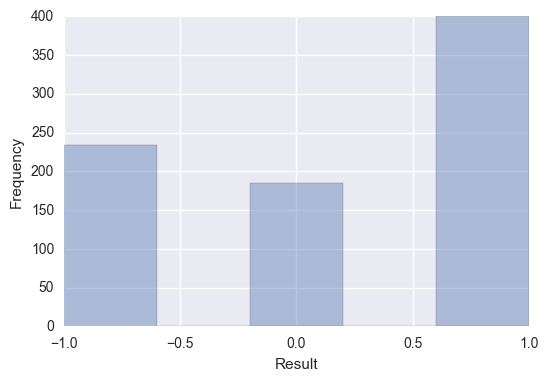

In [175]:
sns.distplot(y_train,kde=False)
plt.ylabel("Frequency")

In [170]:
train_eda = pd.concat([X_train,y_train],axis=1,join='outer')

train_eda.shape

(819, 13)

(-0.25, 0.5)

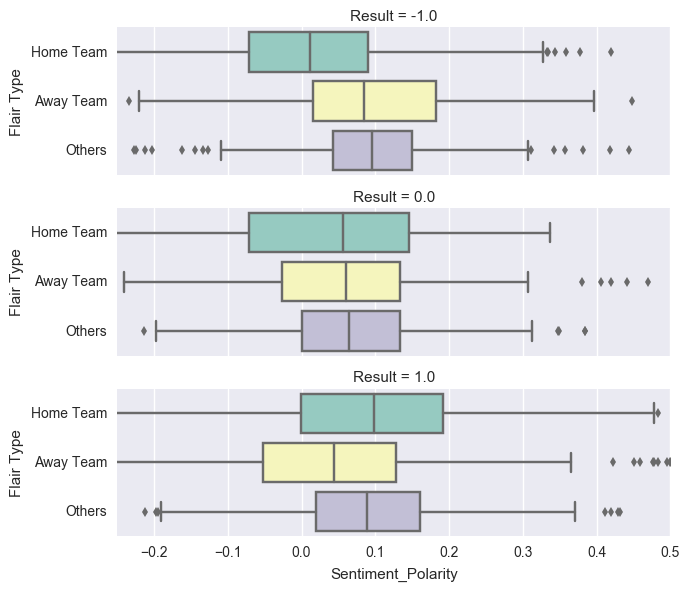

In [236]:
# Reshaping the dataframe with our metrics of interest

df_melt_score = pd.melt(train_eda,
                 id_vars = ['Result'],
                 value_vars = ['Home Team Score Pol','Away Team Score Pol','Others Score Pol'],
                 var_name = 'Flair Type',
                 value_name = 'Sentiment_Polarity')

df_melt_score['Flair Type'] = df_melt_score['Flair Type'].apply(lambda x: x.split(' Score')[0])

plt.figure(figsize=(15,10))
g = sns.factorplot(x="Sentiment_Polarity", y="Flair Type",
                   row="Result",
                   data=df_melt_score[df_melt_score.notnull()],
                   orient="h", size=2, aspect=3.5, palette="Set3",
                   kind="box")

plt.xlim(-0.25,0.5)

*Observations*:
    
1. The median Polarity for Home Team drops when the result is -1 (Home Team Loss). This is expected according to our hypothesis.

2. The median Polarity for Away Team is lowest when the result is 1.0 (Home Team Win).

3. The median Polarity for Others flair type is surprisingly lowest when the result is a draw. 

4. However, the scale of these differences is negligible. For example, the difference in medians for the Home Team between Home Win and Home Loss is 0.1. This is negligible compared to the range of [-1,1] for sentiment polarity we obtained using textblob package. The difference is even more negligible for the other flair types.

Next, I perform statistical test to find out, for each flair type, if the differences in the means of observed sentiment polarities under different classes can be explained by the sampling variability of the null hypothesis.

<a id="stat-inference"></a>

## 5. Inferential Statistics

In this hypothesis, first, I will analyze the statistical significance of the differences in home team sentiment polarities for the groups of home team win, draw and home team loss. This testing will be performed independently for each flair type. The statistical test that best suits this scenario is the 1-way analysis of variance (ANOVA) test.

### 5.1 State Hypothesis

**Null hypothesis:** The mean Home Team comment score-weighted polarity is same for the groups Home Team Win, Draw and Home Team Loss.

**Alternative hypothesis:** The mean Home Team comment score-weighted polarity is different for at least one pair among the groups Home Team Win, Draw and Home Team Loss.

### 5.2 Check Conditions for 1-way ANOVA

- **Independence**: The observations should be independent within and across groups. In our case, each observation represents a separate thread. As there are 500,000 users on the sub and our polarity metric computation that involves only the top 10 comments, we can assume the users contributing to our metrics are different. There is no overlapping of the matches between the groups as the Home team can either lose, win or draw. Hence, the assumption of independence across the groups is reasonable. 

- **Normality**: The data within each group should be nearly normal. Based on the figure below, none of the distributions seem to have exteme skewness.

- **Variability**: Based on the box plots shown above, the variability for the Home Team is nearly same across the groups with a slightly bigger variation when there is a draw. 

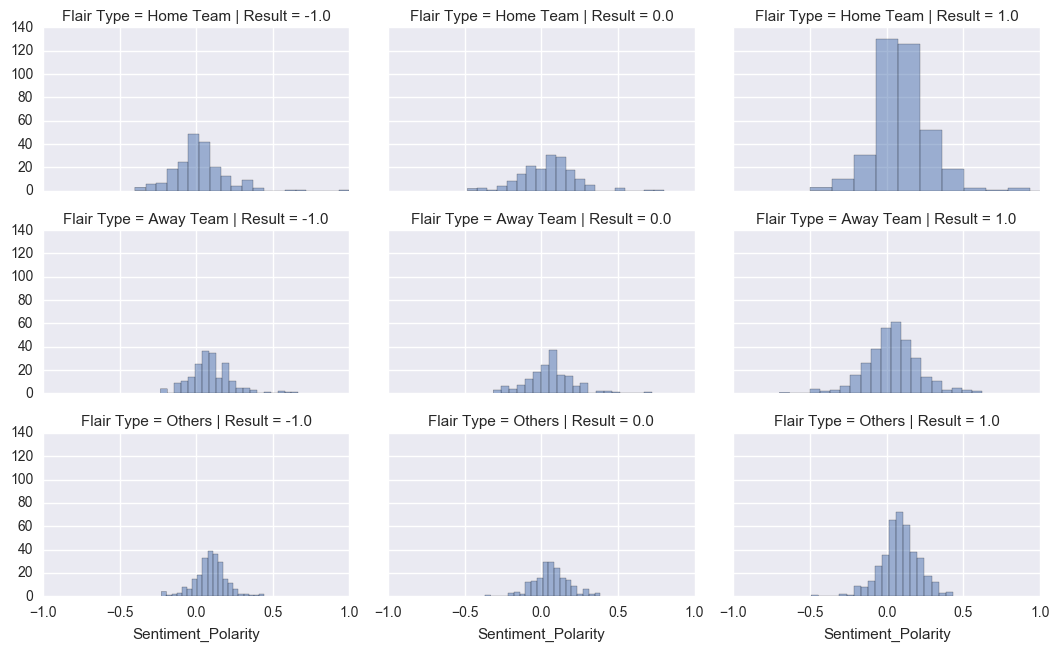

In [237]:
grid = sns.FacetGrid(df_melt_score, col='Result', row='Flair Type', size=2.2, aspect=1.6, xlim=(-1,1))
grid.map(plt.hist, 'Sentiment_Polarity', alpha=.5, bins=20)
grid.add_legend();

In [240]:
def anova_test(df,flair_type):
    anova_df = df.loc[df['Flair Type']==flair_type].dropna()
    mod = ols('Sentiment_Polarity ~ Result',
                data=anova_df).fit()
    return(sm.stats.anova_lm(mod, typ=2))


print("HOME TEAM ANOVA test")
print(anova_test(df_melt_score,'Home Team'))
print("AWAY TEAM ANOVA test")
print(anova_test(df_melt_score,'Away Team'))
print("Others ANOVA test")
print(anova_test(df_melt_score,'Others'))

HOME TEAM ANOVA test
             sum_sq     df          F        PR(>F)
Result     1.013946    1.0  27.149419  2.440290e-07
Residual  27.823417  745.0        NaN           NaN
AWAY TEAM ANOVA test
             sum_sq     df          F    PR(>F)
Result     0.385107    1.0  14.738866  0.000135
Residual  18.028769  690.0        NaN       NaN
Others ANOVA test
             sum_sq     df         F    PR(>F)
Result     0.001699    1.0  0.124452  0.724346
Residual  11.153112  817.0       NaN       NaN


*Observations*:

1. Clearly, the p-value for the f-statistic obtained for the Home Team ANOVA test and Away Team ANOVA test are much lower than the significance level of 0.05. This provides us convincing evidence that the means for all possible match results aren't the same for Home Team sentiment polarity and Away Team sentiment polarity.

2. In contrast, the p-value for Others ANOVA test is 0.7243246 and hence we fail to reject the null hypothesis. Combining this test result with our initial exploratory data analysis, we can remove the sentiment metrics related to Others flair type without any harm.

## 6. Data Imputation

In [288]:
X_train.isnull().sum()

Home Team Score Pol       72
Home Team Subject Pol     72
Home Team Pol SD          72
Home Team Merged Pol      16
Away Team Score Pol      127
Away Team Subject Pol    126
Away Team Pol SD         110
Away Team Merged Pol       0
Others Score Pol           0
Others Subject Pol         0
Others Pol SD              0
Others Merged Pol          0
dtype: int64

Values are missing for a Team when there are no commenters in the thread using the team's flair. This is expected at a greater scale for less popular teams/ teams with small fanbase. For polarity metrics, we could have assigned the value of 0 but that would indicate no sentiment. Therefore, the strategy I employ is to fill the missing values using the median value. 

I prefer median imputation as median is more robust to outliers in the data.

In [302]:
from sklearn.preprocessing import Imputer 

Ndim = 13

imr = Imputer(missing_values='NaN', strategy='median', axis=0)
impute_df_train = imr.fit_transform(np.array(X_train.iloc[:,:Ndim]))
impute_df_test = imr.transform(np.array(X_test.iloc[:,:Ndim]))

X_train.iloc[:,:Ndim] = impute_df_train
X_test.iloc[:,:Ndim] = impute_df_test

Now, there are no missing values in our first 12 columns. Let's fill the missing values in Submission Score.

With all missing values filled, let's analyze the relationship of our predictors with the response variable. Before that, let's standardize the distributions of our predictors so they are on the same scale.

Interestingly, 49.7% of the results in our training data set have Team A winning. There is a clear imbalance among the classes.

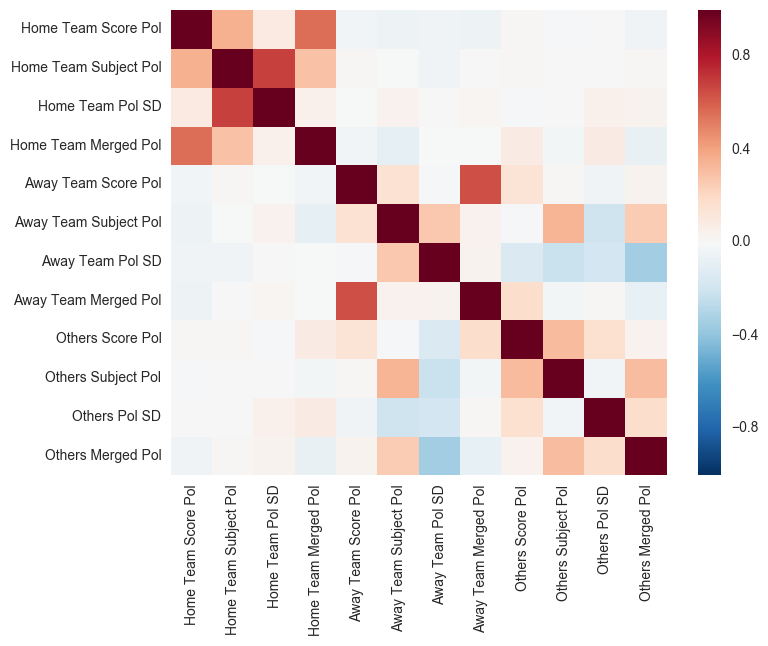

In [298]:
train_corr = X_train.corr()

fig = plt.figure(figsize=(8,6))
sns.heatmap(train_corr,xticklabels=True, yticklabels=True)

*Observations*:

1. Negligible correlation between the sentiment polarities of the Home and Away flair types.

<a id="binary-classification"></a>

## 7. Binary Classification

**To make the problem simpler, I consider a binary classification problem to differentiate between a draw and a win/loss.** I will return to the multi-class classification problem in the future.

In [303]:
# First, let's save our data into a file
f = open("cleaned_data.pckl", "wb")
pickle.dump(X_train,f)
pickle.dump(y_train,f)
pickle.dump(X_test,f)
pickle.dump(y_test,f)

In [304]:
y_train = np.abs(y_train)

y_test = np.abs(y_test)

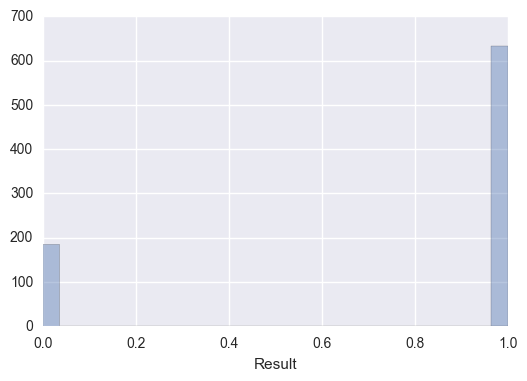

In [274]:
sns.distplot(y_train,kde=False)

Clearly, there is an imbalance among the classes with over 75% belonging to the win/loss class. Let's analyze how sampling during the training places an important role in giving us the right estimate of our training and validation accuracy. Performing basic sampling will give us a overly-optimistic estimate of our performance.

To overcome this, I utilize [SMOTE: Synthetic Minority Over-sampling Technique](https://www.jair.org/media/953/live-953-2037-jair.pdf) implemented in [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn/blob/master/README.rst), a python package offering a number of re-sampling techniques commonly used in datasets showing strong between-class imbalance. It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

### 7.1 Imbalanced Class - Impact of Sampling

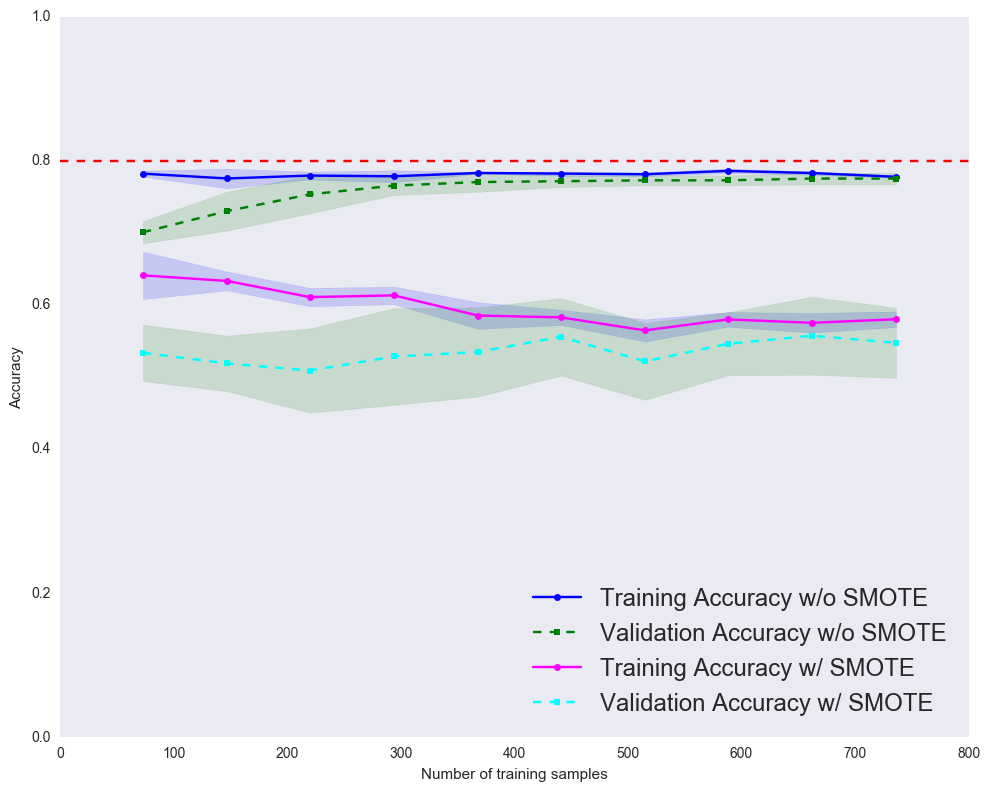

In [305]:
from sklearn.model_selection import learning_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

sm = SMOTE(random_state=42)
scl = StandardScaler()
clf = LogisticRegression(random_state=0)


def generate_accuracy_curve(clf, label_train,label_valid, color_train = 'blue',color_valid='green'):
    """
    Function to generate training and validation curves
    """
    
    train_sizes, train_scores, test_scores =\
                learning_curve(estimator=clf,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    

    plt.plot(train_sizes, train_mean,
             color=color_train, marker='o',
             markersize=5, label=label_train)

    plt.fill_between(train_sizes,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean,
             color=color_valid, linestyle='--',
             marker='s', markersize=5,
             label=label_valid)

    plt.fill_between(train_sizes,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')
    
    return


plt.figure(figsize=(10,8))
    
plt.axhline(y=0.8,
           linestyle = '--',
           color = 'red',
           )

pipe_lr = make_pipeline(scl,clf)
pipe_lr_smote = make_pipeline(sm,scl,clf)

(generate_accuracy_curve(pipe_lr,
                        "Training Accuracy w/o SMOTE",
                        "Validation Accuracy w/o SMOTE",
                        "blue","green"))

(generate_accuracy_curve(pipe_lr_smote,
                        "Training Accuracy w/ SMOTE",
                        "Validation Accuracy w/ SMOTE",
                        "magenta","cyan"))


plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right',fontsize = 'xx-large')
plt.ylim([0, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

We observe both our training and validation accuracy well-below the desired accuracy. This indicates that our simple model underfits the training data.

## 7.2 Ensemble Voting classifier

In [320]:
RANDOM_STATE_SMOTE = 42    
sm = SMOTE(random_state=RANDOM_STATE_SMOTE)    
    
sc = StandardScaler()
    
clf_lr = LogisticRegression(penalty='l2', 
                          C=1,
                          random_state=1)
clf_gnb = GaussianNB()
clf_knn = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe_lr = make_pipeline(sc,clf_lr)
pipe_lr_smote = make_pipeline(sm,sc,clf_lr)
pipe_gnb = make_pipeline(sm,sc,clf_gnb)
pipe_knn = make_pipeline(sm,sc,clf_knn)

clf_vote_soft = VotingClassifier(estimators=[
        ('lr', pipe_lr), ('rf', pipe_rf), ('gnb', pipe_gnb),('knn', pipe_knn)], voting='soft')

clf_labels = ['Logistic Regression', 'Random Forest', 'Gaussian NB', 'KNN','Voting - Soft']
clf_list = [pipe_lr, pipe_rf, pipe_gnb, pipe_knn,clf_vote_soft]

In [321]:
print('10-fold cross validation:\n')
for clf, label in zip(clf_list, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.54 (+/- 0.08) [Logistic Regression]
ROC AUC: 0.55 (+/- 0.08) [Random Forest]
ROC AUC: 0.53 (+/- 0.06) [Gaussian NB]
ROC AUC: 0.50 (+/- 0.05) [KNN]
ROC AUC: 0.54 (+/- 0.04) [Voting - Soft]


### 7.3 Classification Report

In [309]:
pipe_gnb.fit(X_train,y_train)
y_pred = pipe_gnb.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['Draw','Win/Loss']))

             precision    recall  f1-score   support

       Draw       0.20      0.89      0.33        19
   Win/Loss       0.78      0.10      0.17        73

avg / total       0.66      0.26      0.20        92



In [313]:
pipe_rf.fit(X_train,y_train)
y_pred = pipe_rf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['Draw','Win/Loss']))

             precision    recall  f1-score   support

       Draw       0.22      0.53      0.31        19
   Win/Loss       0.80      0.51      0.62        73

avg / total       0.68      0.51      0.56        92



*Observations*:
The Gaussian NB and Random Forest Classifiers differ in their Recalls. Gaussian NB has a high Recall of 0.89 for Draw

<a id = "conclusion"></a>

## 8. Conclusion

In this project, I analyzed the sentiment polarity in the comments of Reddit's soccer subreddit. Using statistical tests, I found convincing evidence that the mean comment score-weighted sentiment polarity is different across match results for Home team commenters and Away team commenters. Next, I perform data cleaning to prepare the data for prediction analysis. I showed that when there are imbalanced classes, under-sampling and over-sampling techniques are essential for a more realistic estimate of the performance. Finally, I compared various machine learning models and showed that Sentiment polarity metrics in isolation provide poor performance in Match Result prediction.